# Analysis of the NYC bike trip data from the last month
The data has been download from https://s3.amazonaws.com/tripdata/index.html
The aim is to address the following requirement:
*  The manager wants to add insurance coverage for the rides that last more than 30 minutes
    *  How many trips would be covered?
    *  If we could charge 0.2 USD for each ride that takes longer than 30 minutes, how much revenue could we expect?
*  The manager wants to understand the travel distance in distance buckets (0-1,2-4,4-9,10+). Please make a diagram.



### Import libraries

In [43]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, array
import pyspark.sql.types as tp
import matplotlib.pyplot as plt
import pandas as pd
from geopy.distance import geodesic

### Setup spark session

In [44]:
spark = SparkSession.builder \
    .appName("NYC bike trip analysis") \
    .getOrCreate()

### Load the data from the last month
*Assumption: I have used the last available file from the AWS bucket, which is supposed to cover September*

In [45]:
df = spark.read.csv("../data/JC-202409-citibike-tripdata.csv", header=True, inferSchema=True)

### Placeholder for basic EDA
*Please uncomment the desired line of code before running*

In [46]:
#df.show()
#df.count()
#df.printSchema()
#df.summary().show()

### Identify how many trips take longer than 30 minutes

-  In the first step the new column *seconds_diff*, which calculates the duration of the trip in seconds, is added. By converting it to long, the values will be converted to unix epoch time in seconds and difference will be also is seconds
-  In the second step the dateframe is filtered to find the trips which take longer than 30 minutes

In [47]:
long_trips_df = df.withColumn('seconds_diff', col('ended_at').cast('long') - col('started_at').cast('long'))
long_trips_cnt = long_trips_df.filter(col('seconds_diff')/60 > 30).count()

#long_trips_df.show()

print(f'There are {long_trips_cnt} trips in the last month taking longer than 30 minutes')


There are 4773 trips in the last month taking longer than 30 minutes


### Calculating expected revenue if we charge 0.2 USD for each ride that takes longer than 30 minutes


In [48]:
charge_per_trip = 0.2
expected_revenue = long_trips_cnt * charge_per_trip
print(f"Potential revenue from long trips: ${expected_revenue:.2f}")

Potential revenue from long trips: $954.60


### Calculating trips distance

-  I have used the well known library for geospatial calculations in python https://geopy.readthedocs.io/en/stable/index.html?highlight=distance#module-geopy.distance
-  The alternative will be to used the Haversine formula https://en.wikipedia.org/wiki/Haversine_formula here is an example of the implementation in python https://www.geeksforgeeks.org/haversine-formula-to-find-distance-between-two-points-on-a-sphere/


In [49]:
def distance(coord_start, coord_end):
    return geodesic(coord_start, coord_end).m #in meters

#registering udf
distance_udf = udf(distance, tp.FloatType())

distance_df = df.withColumn('distance_m', distance_udf(array("start_lat", "start_lng"), array("end_lat", "end_lng")))

#df_distance.show()


### Adding buckets for the distance: (0-1,2-4,4-9,10+)

<font color='red'>The buckets provided in the requirement have gaps, for example there is no coverage for 1-2 and 9-10, therefore I have ammended it to (0-1, 1-4, 4-10, 10+) </font>

*I think that there should be an additional column in the source data which provides the distance. Firstly, the calculated distance is the shortest distance between the start and the end coordinations, the trip will be longer as it is never a straight line between these points. Secondly, if the start and the end point are equal the distance will be incorrectly calculated as 0.*

In [50]:
def distance_bucket(distance):
    if distance <= 1:
        return "0-1"
    elif distance <= 4:
        return "1-4"
    elif distance <= 10:
        return "4-10"
    else:
        return "10+"
    
#registering udf
distance_bucket_udf = udf(distance_bucket, tp.StringType())

distance_buckets_df = distance_df.withColumn('distance_bucket', distance_bucket_udf(col('distance_m')/1000))

#df_distance_buckets.show()

### Drawing the plot

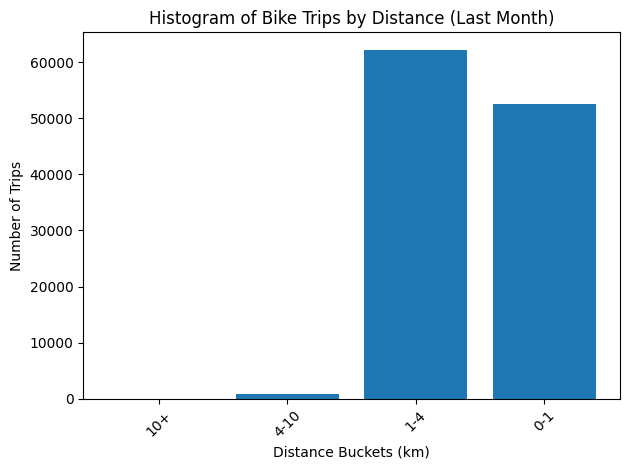

In [51]:
#converting pyspark dataframe to panda dataframe
distance_buckets_pd = distance_buckets_df.groupBy("distance_bucket").count().toPandas()


plt.bar(distance_buckets_pd["distance_bucket"], distance_buckets_pd["count"])
plt.xlabel("Distance Buckets (km)")
plt.ylabel("Number of Trips")
plt.title("Histogram of Bike Trips by Distance (Last Month)")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()